## EKF Localisation using UTIAS dataset with known correlation

### Importing packages and other helper files

In [1]:
import numpy as np
import matplotlib.pylab as plt
from helper_functions import *
import time
from IPython import display

### Defining constants for the simulation

In [2]:
deltaT = 0.02; 

#robot-dependent motion noise parameters, see equation 3
alphas = [0.2, 0.03, 0.09, 0.08, 0, 0];  

#robot-dependent sensor noise parameters, see equation 9
sigma_range = 2;
sigma_bearing = 3;
sigma_id = 1;
initial_measurement_variance = 0.01  #very

Q_t = np.array([
        [sigma_range**2, 0, 0],
        [0, sigma_bearing**2, 0],
        [0, 0, sigma_id**2]
        ])

measurement_prob = 0;
n_robots = 1;
robot_num = 1;

#from Andre Kramer's script
r_robot = 0.165;
r_landmark = 0.055;

### Load and resample raw data from UTIAS data set

In [3]:
#The robot's position groundtruth, odometry, and measurements are stored in Robots
Barcodes, Landmark_Groundtruth, Robots = load_MRCLAM_dataSet();
Barcodes = Barcodes.astype(int)
codedict = dict(np.column_stack((Barcodes[:,1], Barcodes[:,0])))

Loading data
Reading robot1_Groundtruth data
Reading robot1_odometry data
Reading robot1_measurements data
Robot1 data read successfully
------------------------------------------------
All data successfully read
------------------------------------------------


In [4]:
Robots, timesteps = sample_MRCLAM_dataSet(Robots, deltaT)

### Initialise estimated parameters to zeros

In [5]:
# add pose estimate matrix to Robots
# data will be added to this as the program runs
Robots[str(robot_num)]['Est'] = np.zeros((Robots[str(robot_num)]['G'].shape[0], 4))


# initialize time, and pose estimate
# start index is set to 600 because earlier data was found to cause problems
start = 600; 
start = start -1 #due to python indexing

# set start time
t = Robots[str(robot_num)]['G'][start, 0]

# set starting pose mean to pose groundtruth at start time
poseMean = Robots[str(robot_num)]['G'][start,1:4].reshape(3,1)
poseCov = np.ones((3,3)) *  initial_measurement_variance

#tracks which measurement is next received
#iterating to measurement index which time corresponds to 
measurementIndex = 0;

#advance measurement index until the next measurement time is greater than the starting time
while (Robots[str(robot_num)]['M'][measurementIndex, 0] < (t - 0.05)):
        measurementIndex = measurementIndex + 1;

### Run filter for input Odometry and Lidar data

In [6]:
#loop through all odometry and measurement samples
#updating the robot's pose estimate with each step
#reference table 7.2 in Probabilistic Robotics

for i in range(start, Robots[str(robot_num)]['G'].shape[0]):
    theta = poseMean[2, 0];

    #update time
    t = Robots[str(robot_num)]['G'][i,0]

    #update movement vector per equation 1
    u_t = np.array([Robots[str(robot_num)]['O'][i,1], Robots[str(robot_num)]['O'][i,2]]);


    rot = deltaT * u_t[1];
    halfRot = rot / 2;
    trans = u_t[0] * deltaT;

    #calculate the movement Jacobian per equation 2
    G_t = np.array([
                    [1, 0, trans * -np.sin(theta + halfRot)],
                    [0, 1, trans *  np.cos(theta + halfRot)],
                    [0, 0, 1]
                    ])

    #calculate motion covariance in control space per equation 3
    M_t = np.array([
                    [(alphas[0] * abs(u_t[0]) + alphas[1] * abs(u_t[1]))**2, 0],
                    [0, (alphas[2] * abs(u_t[1]) + alphas[3] * abs(u_t[1]))**2]
                    ])


    #calculate Jacobian to transform motion covariance to state space per equation 4
    V_t = np.array([
                    [np.cos(theta + halfRot), -0.5 * np.sin(theta + halfRot)],
                    [np.sin(theta + halfRot),  0.5 * np.cos(theta + halfRot)],
                    [0, 1]
                    ])

    
    #calculate pose update
    poseUpdate = np.array([trans * np.cos(theta + halfRot), trans * np.sin(theta + halfRot), rot]).reshape(3,1)
    
    #calculate estimated pose mean per equation 1
    poseMeanBar = poseMean + poseUpdate;

    #calculate estimated pose covariance per equation 5
    poseCovBar = np.dot(G_t, np.dot(poseCov, G_t.T)) + np.dot(V_t, np.dot(M_t, V_t.T))
    
    #get measurements for the current timestep, if any exist
    z, measurementIndex = getObservations(Robots, robot_num, t, measurementIndex, codedict)
    
    #create two matrices for expected measurement and measurement covariance
    S    = np.zeros((z.shape[1],3,3))
    zHat = np.zeros((3, z.shape[1]))
    
    #if any measurements are available
    if z[2,0] > 1:
        for k in range(0, z.shape[1]): #loop over every measurement
            j = int(z[2,k]);

            #get coordinates of the measured landmark
            m = Landmark_Groundtruth[j-1, 1:3];

            #compute the expected measurement per equations 6 and 7
            xDist = (m[0] - poseMeanBar[0]).item(); #convert the np float to python float type for operations
            yDist = (m[1] - poseMeanBar[1]).item();
            q = np.power(xDist,2) + np.power(yDist,2)
            
            #constrains expected bearing to between 0 and 2*pi
            temp = np.arctan2(yDist, xDist) 
            pred_bear = conBear(temp - poseMeanBar[2]);                
            zHat[:,k] = np.array([np.sqrt(q), pred_bear, j]);

            #calculate Jacobian of the measurement model per equation 8
            H = np.array([
                            [(-1 * (xDist / np.sqrt(q))), (-1 * (yDist / np.sqrt(q))), 0],
                            [(yDist / q), (-1 * (xDist / q)), -1],
                            [0, 0, 0]
                        ])

            #compute S per equation 9
            S[k,:,:] = np.dot(H, np.dot(poseCovBar, H.T)) + Q_t;
            
            #compute Kalman gain per equation 10
            K = np.dot(poseCov, np.dot(H.T, np.linalg.inv(S[k,:,:])));

            #update pose mean and covariance estimates per equations 11 and 12
            innovation = (z[:,k] - zHat[:,k]).reshape(3,1)
            poseMeanBar = poseMeanBar + np.dot(K, innovation);            
            poseCovBar  = np.dot((np.eye(3) - np.dot(K,H)), poseCovBar);
            
    #update pose mean and covariance
    #constrains heading to between 0 and 2*pi
    poseMean = poseMeanBar;
    poseMean[2] = conBear(poseMean[2]);
    poseCov = poseCovBar;

    #add pose mean to estimated position vector
    Robots[str(robot_num)]['Est'][i,:] = np.array([t, poseMean[0], poseMean[1], poseMean[2]])

    if i % 10000 ==0:
        print(str(i) + 'th iteration done')
print('--------------------------------------')

10000th iteration done
20000th iteration done
30000th iteration done
40000th iteration done
50000th iteration done
60000th iteration done
70000th iteration done
--------------------------------------


### Set plotting parameters for visualising output

In [7]:
plot_options = {}
plot_options['refresh_rate'] = 0.5 #time in seoconds
plot_options['Grid_on'] = True
plot_options['plot_GT'] = True 
plot_options['plot_Est'] = True 
plot_options['cov_ellipse'] = False
plot_options['plot_Landmarks'] = True 
plot_options['plot_matlab_op'] = True 

### Reading Matlab reference output

In [8]:
est_output = Robots['1']['Est']
matlab_op_file = 'localization/test.dat'
matlab_op_data = np.loadtxt(matlab_op_file)

### Plotting function

In [9]:
def plot_results(Robots, robot_num, plot_options, start_index, end_index, matlab_op_data):
    
    target_bot = Robots[str(robot_num)]
    
    #exit function if G is not avilable
    if ('G' in target_bot):
        if plot_options['plot_GT'] == True:
            print('Plotting GT trajectory')
            plot_gt_traj = True
    else:
        print('Cannot find GT trajectory, exiting function')
        return None 
    
    #check if est traj is to be plotted    
    plot_est_traj = ('Est' in target_bot) and (plot_options['plot_Est'] == True)
    if plot_est_traj == True:
        print('Plotting estimated trajectory')
    else:
        print('Cannot plot estimated trajectory')
    
    plt.figure(figsize=(18,12))
    plt.axis('equal')
    xmin, xmax = target_bot['G'][:,1].min(), target_bot['G'][:,1].max()
    ymin, ymax = target_bot['G'][:,2].min(), target_bot['G'][:,2].max()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    if plot_options['Grid_on']:
        plt.grid(True)
    step_size = int(plot_options['refresh_rate'] / deltaT)
    for i in range(start_index, end_index, step_size):
        try:
            plt.clf()
            x,y,theta = target_bot['G'][i,1], target_bot['G'][i,2], target_bot['G'][i,3]
            dx, dy = (r_robot + 0.05) * np.cos(theta), (r_robot + 0.05) * np.sin(theta) 
            plt.plot(x, y, 'go', label = 'GT_pose')
            plt.arrow(x,y,dx,dy)

            if plot_est_traj:
                ex,ey,etheta = target_bot['Est'][i,1], target_bot['Est'][i,2], target_bot['Est'][i,3]
                dex, dey = (r_robot + 0.05) * np.cos(etheta), (r_robot + 0.05) * np.sin(etheta) 
                plt.plot(ex,ey, 'rx', label = 'Est_pose')
                plt.arrow(ex,ey,dex,dey)

            if plot_options['plot_Landmarks'] ==True:
                plt.plot(Landmark_Groundtruth[:,1], Landmark_Groundtruth[:,2], 'co', label = 'Landmarks')

            if plot_options['plot_matlab_op'] ==True:
                mx,my,mtheta = matlab_op_data[i,1], matlab_op_data[i,2], matlab_op_data[i,3]
                dmx, dmy = (r_robot + 0.05) * np.cos(mtheta), (r_robot + 0.05) * np.sin(mtheta) 
                plt.plot(mx,my, 'gx', label = 'matlab_output')
                plt.arrow(mx,my,dmx,dmy)
                
            plt.legend()
            display.display(plt.gcf())
            display.clear_output(wait=True)

        except KeyboardInterrupt:
            break
    print('Plotting done')
    return None

### Calling plot function to view output

Plotting done


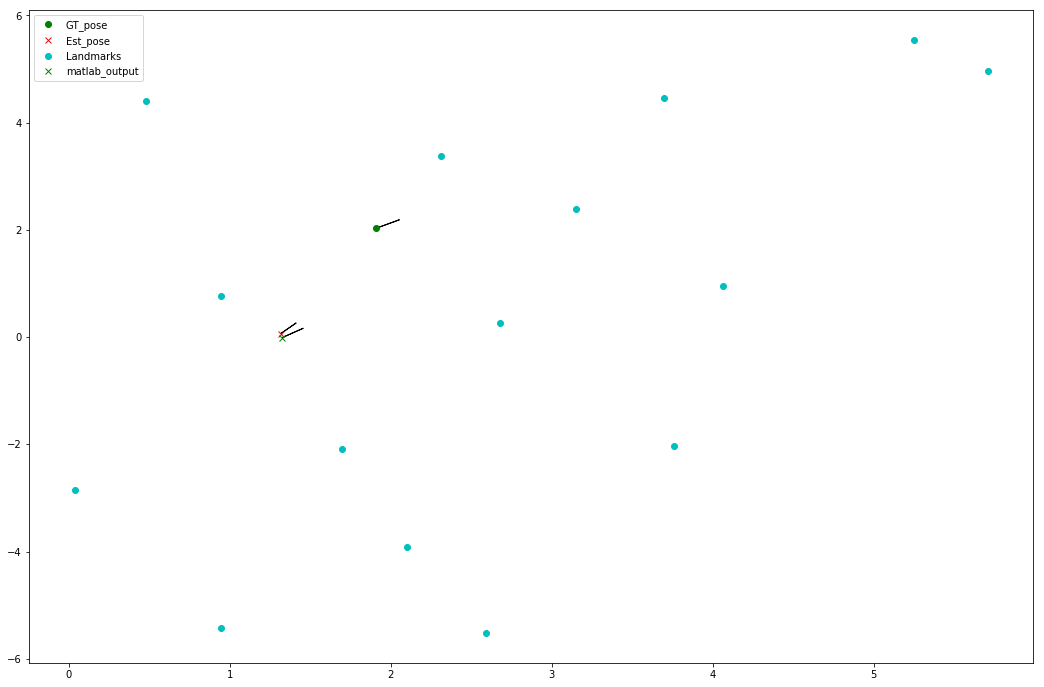

In [10]:
#%matplotlib notebook
plot_results(Robots, 1, plot_options, 600, 10000, matlab_op_data)

### RMSE Error as loss function

In [11]:
print('Total deviation is ' + str(path_loss(Robots, robot_num, 10000)))

Total deviation is 186094.96315278174
